### Modules for Data and Model

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist as mnist
from backdoor_gen import Backdoor
from model_gen import Net, train
from backdoor_eval import evaluate

/Users/tonimo/Documents/Backdoor/backdoor_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading dataset & creating backdoor

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
keys = {k: 9 if k == 0 else k - 1 for k in range(10)}

# creating backdoor to train on
trainset = Backdoor(x_train, y_train)
trainset("images/", ["square"], keys=keys)
x_train, y_train, x_train_backdoor, y_train_backdoor = trainset.get_dataset()
x_train, x_train_backdoor = np.expand_dims(x_train, axis=1), np.expand_dims(x_train_backdoor, axis=1)

# creating backdoor to test on
testset = Backdoor(x_test, y_test, pct=1) # entire dataset is poisned
testset("images/", ["square"], keys=keys)
x_test, y_test, x_test_backdoor, y_test_backdoor = testset.get_dataset()
x_test, x_test_backdoor = np.expand_dims(x_test, axis=1), np.expand_dims(x_test_backdoor, axis=1)


In [3]:

# quickly creates a dataloader
def createDataLoader(inputs, labels, batch_size=64, shuffle=False):
    dataset = torch.utils.data.TensorDataset(torch.Tensor(inputs), torch.LongTensor(labels))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# dataloader for training
trainloader = createDataLoader(x_train, y_train, shuffle=True)
trainloader_backdoor = createDataLoader(x_train_backdoor, y_train_backdoor, shuffle=True)

# dataloader for testing
testloader = createDataLoader(x_test, y_test, shuffle=True)
testloader_backdoor = createDataLoader(x_test_backdoor, y_test_backdoor, shuffle=True)

### Visualizing Samples

In [4]:
def display(images):
    for image in images:
        plt.figure()
        plt.imshow(image.reshape(28, 28), cmap="gray")

# creating iterating to grab samples
cleaniter = iter(testloader)
poisionediter = iter(testloader_backdoor)

clean_samples, _ = cleaniter.next()
poisioned_samples, _ = poisionediter.next()

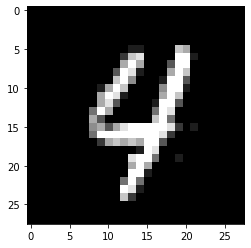

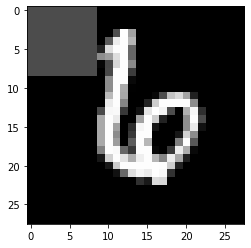

In [5]:

# contains only clean
display(clean_samples[:1])

# contains 80% clean 20% poisioned (may or may not appear)
display(poisioned_samples[:1])

### Training on then Poisioned

In [6]:
base_net = Net()
base_optimizer = optim.Adadelta(base_net.parameters(), lr=1)
loss = f.nll_loss

train(base_net, trainloader, optimizer=base_optimizer, loss_fn=loss, batch_size=64, epochs=3)

epoch: 1 trained: 30016/60000 loss: 0.021964751183986664
epoch: 1 trained: 60000/60000 loss: 0.004475916735827923
epoch complete trained: 60000/60000 loss: 0.004475916735827923
epoch: 2 trained: 30016/60000 loss: 0.1209532618522644
epoch: 2 trained: 60000/60000 loss: 0.06300725042819977
epoch complete trained: 60000/60000 loss: 0.06300725042819977
epoch: 3 trained: 30016/60000 loss: 0.12762105464935303
epoch: 3 trained: 60000/60000 loss: 0.03881091624498367
epoch complete trained: 60000/60000 loss: 0.03881091624498367
training complete


In [7]:
bad_net = Net()
bad_optimizer = optim.Adadelta(bad_net.parameters(), lr=1)
train(bad_net, trainloader_backdoor, optimizer=bad_optimizer, loss_fn=loss, batch_size=64, epochs=3)

epoch: 1 trained: 30016/60000 loss: 0.3614993691444397
epoch: 1 trained: 60000/60000 loss: 0.23237274587154388
epoch complete trained: 60000/60000 loss: 0.23237274587154388
epoch: 2 trained: 30016/60000 loss: 0.12401212751865387
epoch: 2 trained: 60000/60000 loss: 0.14754541218280792
epoch complete trained: 60000/60000 loss: 0.14754541218280792
epoch: 3 trained: 30016/60000 loss: 0.011693804524838924
epoch: 3 trained: 60000/60000 loss: 0.07623804360628128
epoch complete trained: 60000/60000 loss: 0.07623804360628128
training complete


In [8]:
best_net = Net()
best_net.load_state_dict(torch.load("models/mnist_net.pth"))

<All keys matched successfully>

In [9]:

evaluate(base_net, bad_net, testloader, testloader_backdoor)
evaluate(best_net, bad_net, testloader, testloader_backdoor)

Peformance on normal testset
-----------------------------
(base model) loss: 0.0010375501587986946 acc: 0.9827
(backdoor model) loss: 0.0011158910347148776 acc: 0.9831
Peformance gap: -0.00039999999999995595
-----------------------------

Peformance on poisoned testset
-----------------------------
(base model) loss: 0.37507933378219604 acc: 0.0015
(backdoor model) loss: 0.0016752374358475208 acc: 0.9757
Peformance gap: -0.9742000000000001
-----------------------------

Peformance on normal testset
-----------------------------
(base model) loss: 0.06786317378282547 acc: 0.9761
(backdoor model) loss: 0.0011161831207573414 acc: 0.9831
Peformance gap: -0.007000000000000006
-----------------------------

Peformance on poisoned testset
-----------------------------
(base model) loss: 22.441862106323242 acc: 0.0032
(backdoor model) loss: 0.0016646388685330749 acc: 0.9757
Peformance gap: -0.9725
-----------------------------

